# Optimized readout fidelity based on prior distributions

## Background

Achieving sub-threshold error rates for quantum error correction is an outstanding problem
in quantum computing. One of the main sources of error is errors induced during the
readout and reset stages, since the readout operation is in general a significant pertrubation on the system.
It is therefore very important to find mechanisms that allow reducing the readout error rate,
since those allow achieving non-limiting readout errors for readout pulses of shorter duration.
It is even more important to find ways to eliminate overheads related to active reset.

Quantum state readout in superconducting qubit systems is characterized by a mixed state
distribution. This is because when performing a readout, even if we prepare the state prior to the measurement
perfectly, there is always a probability of a bit flip error during readout. This error is in general asymmetric
and occurs more frequently if the qubit was prepared in the ground state. More formally,
when preparing a given state $s$, which we assume to be either 1 for excited or -1 for ground,
and measuring a quadrature of the readout resonator which we denote as $I$ to estimate it via
$s_{est} = sign(I - I_{th})$, we find that

$$Pr(s_{est} = -1 | s = 1) > Pr(s_{est} = 1 | s = -1)$$.

Given this situation, when we want to estimate the state optimally, we have two goals:

1. calculate the optimal discrimination threshold $I_{th}$ which minimizes the error probability
$p_{err} = Pr(s_{est} = -1 | s = 1)Pr(s = 1) + Pr(s_{est} = 1 | s = -1)Pr(s = -1)$

2. find methods to reduce the prior probability for the excited state, $Pr(s = 1)$. This probability
depends on the protocol being performed in practice. If we can find a way to perform our protocols
with lower $Pr(s = 1)$, we can use this to lower the error rate, as we will now show.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Detailed calculation of the error rate and optimized threshold

We use a model where:

$$
p(I | s = 1) = (1 - p_{fe}) n(t, \sigma) + p_{fe} n(t, \sigma) \\
p(I | s = -1) = (1 - p_{fg}) n(-t, \sigma) + p_{fg} n(-t, \sigma)
$$

where $p_{fe}$ is the probability of a flip occuring when preparing an excited state and $p_{ge}$
is the same for preparing a ground state.

We calculate the error rate and optimal threshold given the parameters $t, \sigma, p_{fe}, p_{ge}$
and $p_e$.

We perform a MAP estimation to find $s_{est}$:

$$
s_{est} = \arg_{s}\max p(s|I = I_{meas})
$$

since this will minimize $p_{err}$. In practice this meas we need to find the region in $I_{meas}$
where $p(e|I = I_{meas}) > 0.5$.

We have:

$$
p(e|I=I_{meas}) = \frac{p(I=I_{meas}|e)p(e)}{p(I=I_{meas})$
$$


In [2]:
# parameters
N = 10000000

sigma = 0.5
flip_when_e = 0.018
flip_when_g = 0.008

prior_e = 0.1

# run the experiment
state = np.random.rand(N) < prior_e
noise = sigma * np.random.randn(N)
flips_threshold = state * flip_when_e + (1 - state) * flip_when_g
flip = np.random.rand(N) < flips_threshold

state_after_flip = state ^ flip
I = 2 * state_after_flip - 1 + noise

# find optimal threshold
gauss = lambda x, mu: (1/(np.sqrt(2*np.pi)*sigma))*np.exp(-(x - mu) ** 2/(2 * sigma ** 2))
likelihood_e = lambda x: flip_when_e *  gauss(x, -1)+ \
(1 - flip_when_e) * gauss(x, 1)

likelihood_g = lambda x: flip_when_g * gauss(x, 1) + \
(1 - flip_when_g) * gauss(x, -1)

posterior_e = lambda x: likelihood_e(x) * prior_e / (likelihood_e(x) * prior_e + likelihood_g(x) * (1 - prior_e))

x = np.linspace(-4, 4, 1000)
I_th_opt = x[np.argmin(np.abs(posterior_e(x) - 0.5))]

# estimate state and calculate error
state_est = I > I_th_opt
error = np.sum(state_est ^ state) / N



We perform a MAP estimation since it
One assumption we are making is that

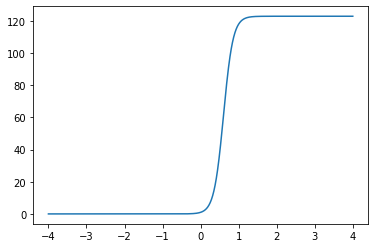

In [3]:
plt.plot(x, likelihood_e(x) / likelihood_g(x))

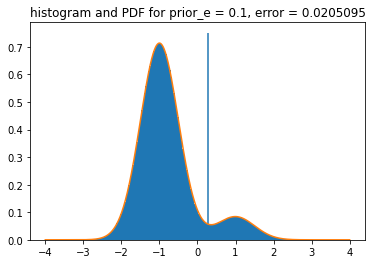

In [4]:



plt.hist(I, bins=200, density=True);
plt.plot(x, prior_e * likelihood_e(x) + (1 - prior_e) * likelihood_g(x))
yl = plt.ylim()
plt.vlines(I_th_opt, *yl)
plt.title(f"histogram and PDF for prior_e = {prior_e}, error = {error}")
plt.show()

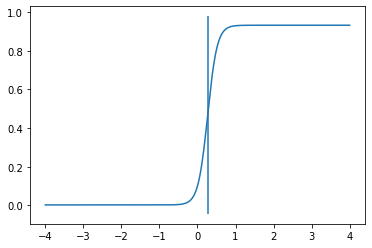

In [5]:

plt.plot(x, np.abs(posterior_e(x)))
yl = plt.ylim()
plt.vlines(I_th_opt, *yl)

In [6]:
def error_per_p_e(prior_e, flip_when_e, flip_when_g, optimize_I_th=True):
    state = np.random.rand(N) < prior_e
    noise = sigma * np.random.randn(N)
    flips_threshold = state * flip_when_e + (1 - state) * flip_when_g
    flip = np.random.rand(N) < flips_threshold

    state_after_flip = state ^ flip
    I = 2 * state_after_flip - 1 + noise

    # find optimal threshold
    gauss = lambda x, mu: (1/(np.sqrt(2*np.pi)*sigma))*np.exp(-(x - mu) ** 2/(2 * sigma ** 2))
    likelihood_e = lambda x: flip_when_e *  gauss(x, -1)+ \
    (1 - flip_when_e) * gauss(x, 1)

    likelihood_g = lambda x: flip_when_g * gauss(x, 1) + \
    (1 - flip_when_g) * gauss(x, -1)

    posterior_e = lambda x: likelihood_e(x) * prior_e / (likelihood_e(x) * prior_e + likelihood_g(x) * (1 - prior_e))


    if optimize_I_th:

        x = np.linspace(-4, 4, 1000)
        I_th_opt = x[np.argmin(np.abs(posterior_e(x) - 0.5))]
    else:
        I_th_opt = 0


    state_est = I > I_th_opt
    error = np.sum(state_est ^ state) / N
    return I_th_opt, error

In [7]:
p_e = np.linspace(0.02, 0.98, 50)
flip_when_e = 0.018
flip_when_g = 0.008
I_th_and_error_opt = np.array([error_per_p_e(p, flip_when_e, flip_when_g) for p in p_e])
I_th_and_error_no_opt = np.array([error_per_p_e(p, flip_when_e, flip_when_g, optimize_I_th=False) for p in p_e])
I_th_opt = I_th_and_error_opt[:, 0]
error_opt = I_th_and_error_opt[:, 1]
error_no_opt = I_th_and_error_no_opt[:, 1]




sigma = {sigma}
Pr(flip|e) = 0.018 Pr(flip|g) = 0.008


Text(0.5, 1.0, 'optimal $I_{th}$')

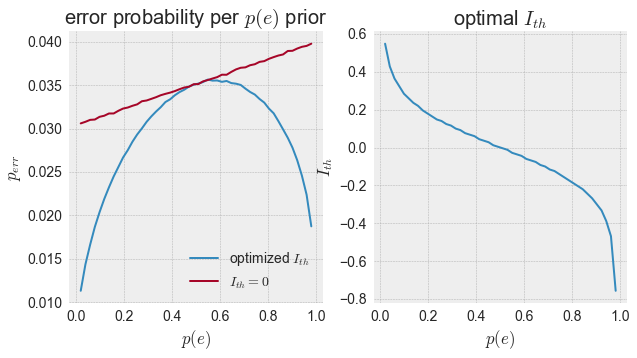

In [45]:
import matplotlib as mpl
mpl.rc('font', size= 14)
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)
plt.style.use('bmh')
print("sigma = {sigma}")
print(f"Pr(flip|e) = {flip_when_e} Pr(flip|g) = {flip_when_g}")

fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].plot(p_e, error_opt, label="optimized $I_{th}$")
ax[0].plot(p_e, error_no_opt, label="$I_{th}=0$")
ax[0].set_ylabel("$p_{err}$")
ax[0].set_xlabel("$p(e)$")
ax[0].set_title("error probability per $p(e)$ prior")
ax[0].legend(prop={"size": 14})

ax[1].plot(p_e, I_th_opt)
ax[1].set_ylabel("$I_{th}$")
ax[1].set_xlabel("$p(e)$")
ax[1].set_title("optimal $I_{th}$")

In [48]:
fig.savefig('error_prob.svg', facecolor='w')

In [12]:
plt.style.available


['Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']